# Using Text Data (Pet Descriptions)
Below, we run a Text Only model as well as a Text model unioned with our numerical model.

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import json

import matplotlib.pyplot as plt

import data
from model import TextOnlyModel, ImageFreeModel, UnionModel

Using TensorFlow backend.


In [2]:
train_images = "data/train_images/*"
test_images = "data/teset_images/*"

breed_labels_file = "data/breed_labels.csv"
state_labels_file = "data/state_labels.csv"
color_labels_file = "data/color_labels.csv"

test_file = "data/test.csv"
train_file = "data/train.csv"

train_sentiment_location = "data/train_sentiment"
test_sentiment_location = "data/test_sentiment"

y_col = 'AdoptionSpeed'

In [3]:
glob("data/**/*.csv",recursive=True)

['data/breed_labels.csv',
 'data/state_labels.csv',
 'data/color_labels.csv',
 'data/test/sample_submission.csv',
 'data/test/test.csv',
 'data/train/train.csv']

In [4]:
breed_labels = pd.read_csv("data/breed_labels.csv")
state_labels = pd.read_csv("data/state_labels.csv")
color_labels = pd.read_csv("data/color_labels.csv")
train_df = pd.read_csv("data/train/train.csv")
test_df = pd.read_csv("data/test/test.csv")

### Text Parsing

#### Process sentiment metadata

In [5]:
preprocessed_file = "sentiment_parsed.csv"
if len(glob(preprocessed_file)) == 0:
    data.get_sentiment(train_df, train_sentiment_location)
else:
    sentiment = pd.read_csv(preprocessed_file)
    train_df = train_df.merge(sentiment, on='PetID')

preprocessed_file = "test_sentiment_parsed.csv"
if len(glob(preprocessed_file)) == 0:
    data.get_sentiment(test_df, test_sentiment_location)
else:
    sentiment = pd.read_csv(preprocessed_file)
    test_df = test_df.merge(sentiment, on='PetID')

#### Parse Description

In [6]:
train_sequence, test_sequence, vocab_len = data.parse_description(train_df, test_df)

In [7]:
train_df['Sequence'] = train_sequence
test_df['Sequence'] = test_sequence

In [8]:
display(train_df[['Sequence']][:10])

,Sequence
0,"[19774, 11870, 15761, 2080, 4366, 15226, 631, ..."
1,"[5218, 9822, 16971, 23797, 8123, 19032, 19461,..."
2,"[12692, 23797, 14231, 3243, 15000, 3753, 15266..."
3,"[13747, 6271, 16322, 8623, 16051, 6279, 13747,..."
4,"[10059, 4366, 14430, 22610, 4409, 16266, 21687..."
5,"[5279, 5867, 9258, 13743, 828, 19906, 0, 0, 0,..."
6,"[1012, 2043, 7728, 2235, 7318, 16566, 11691, 2..."
7,"[3753, 15266, 4409, 2043, 20389, 18254, 8961, ..."
8,"[22977, 8623, 9564, 5867, 5218, 5890, 20086, 1..."
9,"[5637, 1541, 5279, 5218, 21611, 24423, 8538, 5..."


### Preprocess Numeric Data - One hot encoding

In [9]:
# One hot encode columns
for col, num_class in data.one_hot_cols.items():
    if col is not 'Breed1' and col is not 'Breed2':
        encode = data.one_hot_encode(train_df, col, num_class)
        train_df[col] = [row for row in encode]
        encode = data.one_hot_encode(test_df, col, num_class)
        test_df[col] = [row for row in encode]
        print("One hot encoding {} with {} classes...".format(col, num_class))

One hot encoding Type with 2 classes...
One hot encoding Gender with 3 classes...
One hot encoding Color1 with 7 classes...
One hot encoding Color2 with 7 classes...
One hot encoding Color3 with 7 classes...
One hot encoding MaturitySize with 5 classes...
One hot encoding FurLength with 4 classes...
One hot encoding Vaccinated with 3 classes...
One hot encoding Dewormed with 3 classes...
One hot encoding Sterilized with 3 classes...
One hot encoding Health with 4 classes...
One hot encoding State with 15 classes...


In [10]:
# One hot encode y-output
encode = data.one_hot_encode(train_df, y_col)
train_df['AdoptionSpeed'] = [row for row in encode]

### Split into train and validation sets

In [17]:
numeric_cols = ['Age', 'Type', 'Gender', 'Color1', 'Color2',
                'Color3', 'MaturitySize', 'FurLength', 'Vaccinated',
                'Dewormed', 'Sterilized', 'Health', 'Quantity',
                'Fee', 'State', 'VideoAmt', 'PhotoAmt',
                'SentimentMagnitude', 'SentimentScore', 'NumSentences']

In [18]:
text_cols = 'Sequence'

In [19]:
# Split into training and validation data
n_train = int(len(train_df) * .8)

# Text
train_x_text = train_df[text_cols][:n_train]
train_x_text = np.array([row for row in train_x_text]) # To make this correct shape
train_y_text = train_df[y_col][:n_train]
train_y_text = np.array([row for row in train_y_text])
valid_x_text = train_df[text_cols][n_train:]
valid_x_text = np.array([row for row in valid_x_text])
valid_y_text = train_df[y_col][n_train:]
valid_y_text = np.array([row for row in valid_y_text])

# Numeric
train_x_num = train_df[numeric_cols][:n_train]
# train_x_num = np.array([row for row in train_x_num]) # To make this correct shape
train_y_num = train_df[y_col][:n_train]
# train_y_num = np.array([row for row in train_y_num])
valid_x_num = train_df[numeric_cols][n_train:]
# valid_x_num = np.array([row for row in valid_x_num])
valid_y_num = train_df[y_col][n_train:]
# valid_y_num = np.array([row for row in valid_y_num])

## Text Only Model
Defined in model.py as TextOnlyModel

In [22]:
text_model = TextOnlyModel((train_x_text, train_y_text),
                           (valid_x_text, valid_y_text),
                           vocab_len)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
description_encoder (Sequent (None, 32)                829088    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 829,253
Trainable params: 829,253
Non-trainable params: 0
_________________________________________________________________


In [23]:
text_model.compile()
text_model.train(epochs=10)

Train on 11994 samples, validate on 2999 samples
Epoch 1/10
11994/11994 [==============================] - 51s 4ms/step - loss: 1.4767 - acc: 0.2774 - val_loss: 1.4609 - val_acc: 0.3028
Epoch 2/10
11994/11994 [==============================] - 42s 4ms/step - loss: 1.4469 - acc: 0.3189 - val_loss: 1.4400 - val_acc: 0.3154
Epoch 3/10
11994/11994 [==============================] - 42s 3ms/step - loss: 1.3589 - acc: 0.3914 - val_loss: 1.4399 - val_acc: 0.3378
Epoch 4/10
11994/11994 [==============================] - 40s 3ms/step - loss: 1.2729 - acc: 0.4248 - val_loss: 1.4511 - val_acc: 0.3281
Epoch 5/10
11994/11994 [==============================] - 40s 3ms/step - loss: 1.1943 - acc: 0.4687 - val_loss: 1.5254 - val_acc: 0.3304
Epoch 6/10
11994/11994 [==============================] - 39s 3ms/step - loss: 1.1129 - acc: 0.5151 - val_loss: 1.6375 - val_acc: 0.3368
Epoch 7/10
11994/11994 [==============================] - 41s 3ms/step - loss: 1.0243 - acc: 0.5711 - val_loss: 1.7952 - val_acc:

In [24]:
history = text_model.model.history

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


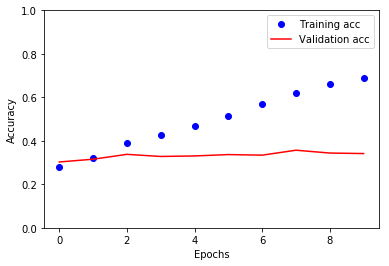

In [25]:
print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc'] # This isn't here?

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

## Numerical + Text Data
Combining ImageFreeModel with TextOnlyModel using UnionModel

In [26]:
numerical_model = ImageFreeModel((train_x_num, train_y_num),
                                 (valid_x_num, valid_y_num))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_free_encoder (Sequenti (None, 64)                11464     
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 325       
Total params: 11,789
Trainable params: 11,337
Non-trainable params: 452
_________________________________________________________________


In [27]:
numerical_model.compile()
numerical_model.train(epochs=10)

ValueError: Error when checking input: expected image_free_encoder_input to have shape (34,) but got array with shape (20,)

In [ ]:
# TODO - also how to pass this data
# UnionModel([numerical_model, text_model],)